<Figure size 432x288 with 0 Axes>

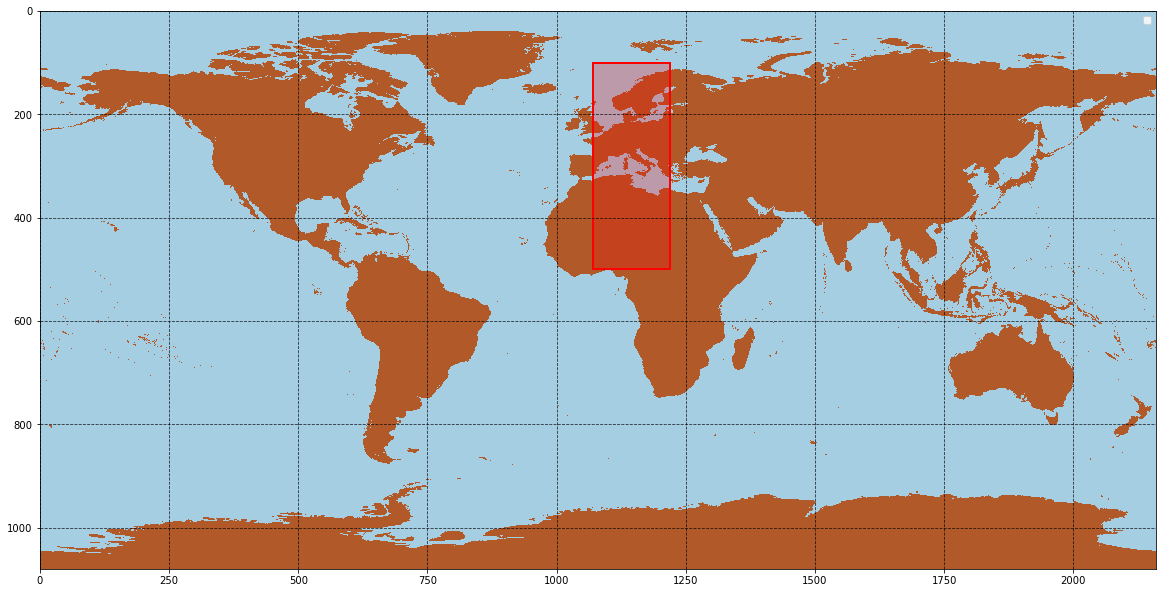

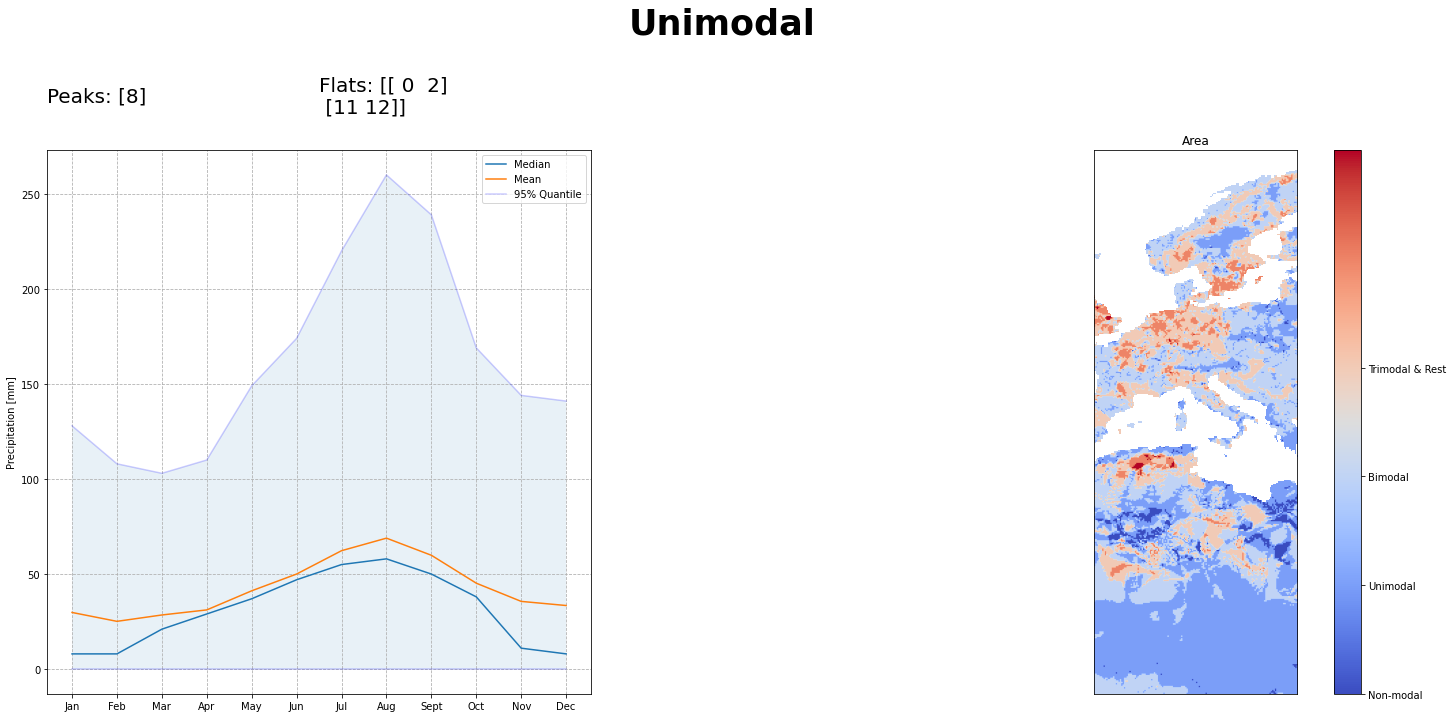

<Figure size 1800x288 with 0 Axes>

Duration: 0:15:49.233749


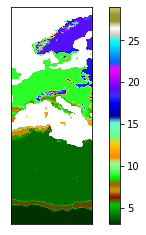

In [2]:
from datetime import datetime
start_time = datetime.now()
import rasterio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl

# sys.path is a list of absolute path strings
import sys
sys.path.append(r'C:\Users\owner\Google Drive 2\ELGO Paper')
from modality import Modality
from Koppen_class import Koppen

#Set the new matrices
mod = []
flats = []
peak = []
med = []
text = []
w = []
T = []
kop = []

#Raster read
for im in range(1, 10):
    w1 = (rasterio.open(r'C:\Users\owner\Google Drive 2\ELGO Paper\wc2.1_10m_prec\wc2.1_10m_prec_0{}.tif'.format(im)))
    w.append(w1.read())
for im in range(10, 13):
    w1 = (rasterio.open(r'C:\Users\owner\Google Drive 2\ELGO Paper\wc2.1_10m_prec\wc2.1_10m_prec_{}.tif'.format(im)))
    w.append(w1.read())
for im in range(1, 10):
    w0 = (rasterio.open(r'C:\Users\owner\Google Drive 2\ELGO Paper\wc2.1_10m_tavg\wc2.1_10m_tavg_0{}.tif'.format(im)))
    T.append(w0.read())
for im in range(10, 13):
    w0 = (rasterio.open(r'C:\Users\owner\Google Drive 2\ELGO Paper\wc2.1_10m_tavg\wc2.1_10m_tavg_{}.tif'.format(im)))
    T.append(w0.read())

rows = w1.shape[0]
cols = w1.shape[1]

w = np.reshape(w, (12, rows, cols))
w = w.astype("float")
w[w < 0] = np.nan

T = np.reshape(T, (12, rows, cols))
T = T.astype("float")
T[w == -3.4e+38] = np.nan

n = np.random.randint(0, rows) #y
m = np.random.randint(0, cols) #x 
n = 280     #GREECE
m = 1195    #GREECE

n = 100
m = 1070

k = 150     #Width
l = 400     #Lenght

plt.figure()
for i in range(int(n), int(n) + l):
     for j in range(int(m), int(m) + k):
            P = (w[0][i][j], w[1][i][j], w[2][i][j], w[3][i][j], w[4][i][j], w[5][i][j], w[6][i][j], w[7][i][j], w[8][i][j], w[9][i][j], w[10][i][j], w[11][i][j])
            T0 = (T[0][i][j], T[1][i][j], T[2][i][j], T[3][i][j], T[4][i][j], T[5][i][j], T[6][i][j], T[7][i][j], T[8][i][j], T[9][i][j], T[10][i][j], T[11][i][j])
            classification = Koppen(P, T0, z = 0)[0]
            med.append(P)
            if w[0][i][j] >= 0:
                mod.append(sum(Modality(P)[0]))
                flats.append(Modality(P)[1])
                peak.append(Modality(P)[2])
            else:
                mod.append(np.nan)
                flats.append(np.nan)
                peak.append(np.nan)
            if T[0][i][j] >= -300:
                kop.append(classification)
            else:
                kop.append(np.nan)

#World
months = ('Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sept', 'Oct', 'Nov', 'Dec')
x = np.arange(len(months))
plt.figure(figsize = (20, 20))
mapp = w[0].astype("float")
mapp[np.isnan(mapp)] = -1
mapp[mapp >= 0] = 1
plt.imshow(mapp, cmap = 'Paired', interpolation = 'nearest')
plt.legend([(i,j)])
currentAxis = plt.gca()
currentAxis.add_patch(Rectangle((m, n), k, l, fill = None, alpha = 1, color = 'r', lw = 2))
currentAxis.add_patch(Rectangle((m, n), k, l, alpha = 0.25, color = 'r'))
plt.grid(color = 'black', ls = '--', alpha = 0.8)
plt.show();

#Stats
if not np.isnan(med).all() == True:
    median = pd.DataFrame(np.asarray(med))
    mean = np.mean(median, axis = 0)
    median = np.nanmedian(median, axis = 0)
    histogr = pd.DataFrame(np.asarray(med))
    perc25 = np.nanpercentile((np.asarray(med)), 2.5, axis = 0)
    perc975 = np.nanpercentile((np.asarray(med)), 97.5, axis = 0)
    areamod, areaflat, areapeak = Modality(np.array(median));

    if areamod.sum() == 0:
        text = 'Non-modal'
    if areamod.sum() == 1:
        text = 'Unimodal'
    if areamod.sum() == 2:
        text = 'Bimodal'
    if areamod.sum() == 3:
        text = 'Trimodal'
    if areamod.sum() > 3:
        text = 'Multimodal & rest'
    peaky = f'Peaks: {areapeak}'

    #COOL PLOT
    fig, (ax, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [1.5, 2]}, figsize = (25, 10))
    fig.suptitle(text, x = 0.5, y = 1.08, fontsize=35, fontweight='bold');
    ax.plot(x, median);
    ax.plot(x, mean);
    ax.set_ylabel('Precipitation [mm]');
    ax.plot(months, perc25, color = 'blue', alpha=0.2)
    ax.plot(months, perc975, color = 'blue', alpha=0.2)
    ax.fill_between(months, perc25, perc975, alpha=0.1)
    ax.legend(['Median', 'Mean', '95% Quantile'], loc = 'best');
    ax.grid(ls = '--')

    #Location
    ax2.title.set_text('Area')
    mapping = np.reshape(mod, ((l, k)))
    colormap1 = plt.imshow(mapping, cmap='coolwarm')
    ax2.grid()
    ax2.set_xticks([])
    ax2.set_yticks([])
    cbar2 = plt.colorbar(colormap1, shrink=1)
    cbar2.set_ticks([0, 1, 2, 3])
    cbar2.set_ticklabels(['Non-modal', 'Unimodal', 'Bimodal', 'Trimodal & Rest'])
    if areamod.any() > 0:
        ax2.text(0, 1.1, peaky, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize = 20)
    if len(areaflat) > 0:
        flaty = f'Flats: {areaflat}'
        ax2.text(.5, 1.1, flaty, horizontalalignment='left', verticalalignment='center', transform=ax.transAxes, fontsize = 20)
    
    plt.figure(figsize = (25, 4))
    Koppen_map = np.reshape(kop, ((l, k)))
    mapping2 = Koppen_map.copy()

    mapping2[mapping2 == 'Af - Tropical Wet'] = 0
    mapping2[mapping2 == 'Am - Monsoon'] = 1
    mapping2[mapping2 == 'As - Summer Savannah'] = 2
    mapping2[mapping2 == 'Aw - Winter Savannah'] = 3
    mapping2[mapping2 == 'BWh - Hot Waste'] = 4
    mapping2[mapping2 == 'BWk - Cold Waste'] = 5
    mapping2[mapping2 == 'BSh - Hot Steppe'] = 6
    mapping2[mapping2 == 'BSk - Cold Steppe'] = 7
    mapping2[mapping2 == 'Cfa'] = 8
    mapping2[mapping2 == 'Cfb'] = 9
    mapping2[mapping2 == 'Cfc'] = 10
    mapping2[mapping2 == 'Csa'] = 11
    mapping2[mapping2 == 'Csb'] = 12
    mapping2[mapping2 == 'Csc'] = 13
    mapping2[mapping2 == 'Cwa'] = 14
    mapping2[mapping2 == 'Cwb'] = 15
    mapping2[mapping2 == 'Cwc'] = 16
    mapping2[mapping2 == 'Dfa'] = 17
    mapping2[mapping2 == 'Dfb'] = 18
    mapping2[mapping2 == 'Dfc'] = 19
    mapping2[mapping2 == 'Dfd'] = 20
    mapping2[mapping2 == 'Dsa'] = 21
    mapping2[mapping2 == 'Dsb'] = 22
    mapping2[mapping2 == 'Dsc'] = 23
    mapping2[mapping2 == 'Dsd'] = 24
    mapping2[mapping2 == 'Dwa'] = 25
    mapping2[mapping2 == 'Dwb'] = 26
    mapping2[mapping2 == 'Dwc'] = 27
    mapping2[mapping2 == 'Dwd'] = 28
    mapping2[mapping2 == 'ET - Tundra'] = 29
    mapping2[mapping2 == 'EF - Frost or Ice Cap'] = 30
    mapping2[mapping2 == 'HT - Tundra'] = 31
    mapping2[mapping2 == 'HF - Frost or Ice Cap'] = 32
    
    mapping2 = mapping2.astype("float")
       
    plt.show()
    colors = ["#003300", "#006600", "#009900", "#00cc00", "#990000", "#cc9900", "#996600", "#00ff00", "#66ff66", "#99ff99", "#ff8c00", "#ffae00", "#ffcf00", "#66ff8c", "#66ffae", "#66ffcf", "#000099", "#0000cc", "#0000ff", "#3333ff", "#6600ff", "#9900ff", "#cc00ff", "#ff00ff", "#0066ff", "#0099ff", "#00ccff", "#00ffff", "#cccccc", "#ffffff", "#999933", "999933", "#cccc66" ]
    classes = ['Af - Tropical Wet', 'Am - Monsoon', 'As - Summer Savannah', 'Aw - Winter Savannah','BWh - Hot Waste', 'BWk - Cold Waste', 'BSh - Hot Steppe', 'BSk - Cold Steppe',  'Csa', 'Csb', 'Csc', 'Cwa', 'Cwb', 'Cwc', 'Cfa', 'Cfb', 'Cfc', 'Dsa', 'Dsb', 'Dsc', 'Dsd', 'Dwa', 'Dwb', 'Dwc', 'Dwd', 'Dfa', 'Dfb', 'Dfc', 'Dfd', 'ET - Tundra', 'EF - Frost or Ice Cap', 'HT - Tundra', 'HF - Frost or Ice Cap']

    def hex_to_rgb(value):
        value = value.strip("#") # removes hash symbol if present
        lv = len(value)
        return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))
    
    def rgb_to_dec(value):
        return [v/256 for v in value]
    
    def get_continuous_cmap(hex_list, float_list=None):
        rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
        if float_list:
            pass
        else:
            float_list = list(np.linspace(0,1,len(rgb_list)))
            
        cdict = dict()
        for num, col in enumerate(['red', 'green', 'blue']):
            col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
            cdict[col] = col_list
        cmp = LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
        return cmp
    
    colormap = plt.imshow(mapping2, cmap=get_continuous_cmap(colors))
    plt.grid()
    plt.xticks([])
    plt.yticks([])
    plt.colorbar()
    
#Duration
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))

In [4]:
import gdal
drv = gdal.GetDriverByName("GTiff")
ds.GetRasterBand(1).WriteArray(mapping2)
ds = drv.Create("name.tif", k, l, 6, gdal.GDT_Float32)

AttributeError: type object 'object' has no attribute '__getattr__'